In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scaffold
|Element|Your Plan|
|-|-|
|Hypothesis|MN has a systematic difference in fatal crashes involving interstate junctions than other states.|
|Outcome/Metric/Test Stat|Mean fatal junction related interstate crashes in MN per year - non-MN|
|Unit of Analysis|1 state - year |
|Data Source(s)|https://cdan.dot.gov/query|
|Why this data works|It has yearly counts by state of fatal motor vehicle crashes related to interstate junctions |
|Uncertainty Metric|Number of motor vehicle crashes by state-year |
|Null Hypothesis|Null: MN has no difference in number of fatal interstate junction motor vehicle crashes. |

In [50]:
df = pd.read_csv("CrashReport_filled(in).csv")
print(df.sample(10))
print(df.shape)
print(df.info())
print(df.describe())

                    State      Interstate      Junction  2013  2014  2015  \
494                Nevada      Interstate         Other     9     8    11   
584        North Carolina  Non-Interstate  Non-Junction   829   814   878   
415             Minnesota         Unknown      Junction     0     0     0   
145  District of Columbia  Non-Interstate      Junction    10    10    10   
224                 Idaho           Total         Other    16     8    16   
241              Illinois           Total      Junction   227   241   265   
610          North Dakota           Total      Junction    27    31    20   
830            Washington         Unknown      Junction     3    42     0   
502                Nevada         Unknown  Non-Junction     3    10     5   
151  District of Columbia           Total  Non-Junction     9    10    12   

     2016  2017  2018  2019  2020  2021  2022  2023  Total  
494    11    18     6     3    11    14    10     7    108  
584   934   884   893   900   

In [63]:
# Create a dataframe of just state level
df_merging = df.query("Interstate == 'Interstate' and Junction == 'Junction'").reset_index(drop=True)

# Identify year columns (4-digit column names)
year_cols = [col for col in df_merging.columns 
             if str(col).isdigit() and len(str(col)) == 4]

# Everything else stays as identifiers
id_cols = [col for col in df_merging.columns if col not in year_cols]

# Melt it
df_long = df_merging.melt(
    id_vars=id_cols,
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# ensure year is numeric and get rid of that total
df_long["Year"] = df_long["Year"].astype(int)
df_long["Value"] = pd.to_numeric(df_long["Value"], errors="coerce")
df_merging = df_long.drop(columns = ["Total"])

df_merging = df_merging[df_merging['State']!="Total"].copy()

print(df_merging.isna().sum().sort_values(ascending=False))
print(df_merging.shape)

print(df_merging.sample(5))



State         0
Interstate    0
Junction      0
Year          0
Value         0
dtype: int64
(517, 5)
             State  Interstate  Junction  Year  Value
476  West Virginia  Interstate  Junction  2022      0
520           Utah  Interstate  Junction  2023      1
213      Minnesota  Interstate  Junction  2017      3
225           Ohio  Interstate  Junction  2017      1
142        Wyoming  Interstate  Junction  2015      0


In [68]:
df_merging['MN'] = np.where(df_merging['State'] == 'Minnesota', 'MN', 'Not MN')
#mn_avg_per_yr = df_merging[df_merging['State']=="Minnesota"]["Value"].mean()
#usa_avg_per_year = df_merging[df_merging['State']!="Minnesota"]["Value"].mean()
observed_diff = df_merging.groupby('MN')['Value'].mean().loc['MN'] - df_merging.groupby('MN')['Value'].mean().loc['Not MN']
observed_diff, df_merging.groupby('MN')['Value'].mean().loc['MN'], df_merging.groupby('MN')['Value'].mean().loc['Not MN']

(0.0671936758893279, 1.3636363636363635, 1.2964426877470356)

In [88]:
df_copy = df_merging.copy()
df_copy = df_copy.reset_index(drop=True)

results =[]
n = 10_000

for i in range(n):
    df_copy['MN'] = df_copy['MN'].sample(frac=1,replace=False).values
    #mn_avg = df_copy[df_copy['State']=="Minnesota"]["Value"].mean()
    #usa_avg = df_copy[df_copy['State']!="Minnesota"]["Value"].mean()
    means = df_copy.groupby('MN')['Value'].mean()
    diff = means.loc["MN"] - means.loc["Not MN"]
    results.append(diff)

pval = 0

for i in range(0,n):
    if np.abs(results[i]) > observed_diff:
        pval += 1
    else:
        pval += 0

pval = pval/n

print(f"The p-value is {pval}")


The p-value is 0.9323


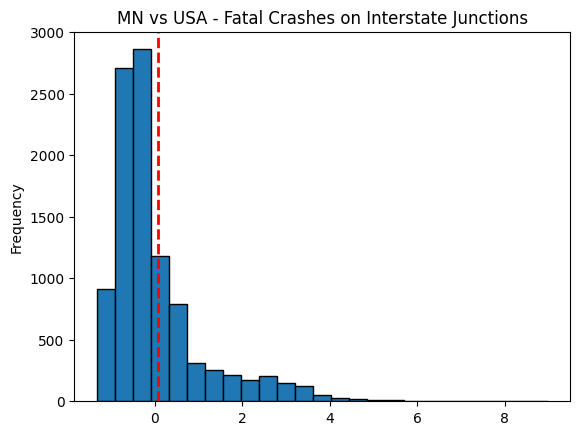

In [89]:
plt.figure()
plt.hist(results, bins = 25, edgecolor ='black')
plt.title("MN vs USA - Fatal Crashes on Interstate Junctions")
plt.ylabel("Frequency")
plt.axvline(x=observed_diff, color='red', linestyle='--', linewidth=2)
plt.show()

### Results for Raw # of Fatal Crashes: MN is not different than the rest of the country

# Now let's look at % of a states fatal crashes on interstate junctions as a % of total fatal crashes

State         0
Interstate    0
Junction      0
Year          0
Value         0
MN            0
dtype: int64


# Add in some data
https://catalog.data.gov/dataset/vehicle-miles-of-travel-by-functional-system-and-state-1980-2023-vm-2?utm_source=chatgpt.com


In [98]:
miles = pd.read_csv("Vehicle_Miles_of_Travel_by_State_1980_to_2023.csv")
miles['Year'] = miles['Year'].astype(int)
miles.sample(10)


,Year,State,Area,FClass,VMT
2257,2020,Colorado,Rural,Minor Arterial,1.964923e+09
28197,1981,Ohio,Urban,Minor Arterial,5.161000e+09
5184,2016,Connecticut,Rural,Major Collector,8.126741e+08
21077,1992,Indiana,Rural,Local,2.577000e+09
14020,2004,Wyoming,Rural,Minor Collector,6.980000e+08
19155,1995,Georgia,Rural,Major Collector,6.362000e+09
10857,2009,Washington,Urban,Interstate,1.079300e+10
7114,2014,South Carolina,Rural,Other Principal Arterial,3.872443e+09
9285,2011,Rhode Island,Rural,Minor Arterial,1.299170e+08
2922,2019,Alabama,Urban,Minor Arterial,7.372662e+09


In [101]:
miles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29016 entries, 0 to 29015
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    29016 non-null  int64  
 1   State   29016 non-null  object 
 2   Area    29016 non-null  object 
 3   FClass  29016 non-null  object 
 4   VMT     29016 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [109]:
miles_clean = miles[(miles['Year']>2012) & (miles['FClass']=="Interstate")].copy()
miles_clean = miles_clean.groupby(['Year','State','FClass'])['VMT'].sum().reset_index()
miles_clean



,Year,State,FClass,VMT
0,2013,Alabama,Interstate,1.390324e+10
1,2013,Alaska,Interstate,1.592795e+09
2,2013,Arizona,Interstate,1.281675e+10
3,2013,Arkansas,Interstate,8.559906e+09
4,2013,California,Interstate,8.599321e+10
...,...,...,...,...
567,2023,Virginia,Interstate,2.688305e+10
568,2023,Washington,Interstate,1.723203e+10
569,2023,West Virginia,Interstate,4.236376e+09
570,2023,Wisconsin,Interstate,1.473948e+10


## Lets find out the number of Fatal Crashes at Interstate Junction **per** Interstate Mile Driven in Each State **per** Year

In [112]:
df_all = pd.merge(df_merging, miles_clean, on=["State", "Year"], how="inner")
df_all.sample(30)

,State,Interstate,Junction,Year,Value,MN,FClass,VMT
511,Vermont,Interstate,Junction,2023,0,Not MN,Interstate,1.709461e+09
184,Washington,Interstate,Junction,2016,1,Not MN,Interstate,1.688427e+10
443,Michigan,Interstate,Junction,2022,0,Not MN,Interstate,2.114959e+10
15,Kentucky,Interstate,Junction,2013,0,Not MN,Interstate,1.318142e+10
375,Wyoming,Interstate,Junction,2020,0,Not MN,Interstate,3.035260e+09
36,Pennsylvania,Interstate,Junction,2013,0,Not MN,Interstate,2.328124e+10
447,Montana,Interstate,Junction,2022,0,Not MN,Interstate,3.446541e+09
276,Vermont,Interstate,Junction,2018,1,Not MN,Interstate,1.825450e+09
312,New York,Interstate,Junction,2019,1,Not MN,Interstate,2.745114e+10
155,Kansas,Interstate,Junction,2016,0,Not MN,Interstate,7.822207e+09
